# AC__TC__2B

Import libraries:

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm


### ESA MAAP (STAC) Catalog API 
Point to the catalogue endpoint

In [2]:
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

In [3]:
EC_COLLECTION = ['EarthCAREL2Validated_MAAP']

**Filter** - allows you to search based on different metadata parameters. To understand which queryables exist you can visit: [Queryables](https://catalog.maap.eo.esa.int/catalogue/collections/EarthCAREL1Validated_MAAP/queryables). 
Examples include: 
* productType
* frame 
* processingLevel
* instrument
* orbitNumber 
... 

**Datetime** represents the temporal coverage of the data. None can be used for both start and end to indicated unbounded queries.  

**bbox** is defined by the bottom left corner (longmin latmin) and the top right corner coordinates (longmax latmax) 


In [4]:
search = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'AC__TC__2B' and (frame = 'E' or frame = 'A')", # Filter by product type
    bbox = [100, -15, 160, 30],
    #datetime = ['2025-06-06T00:00:00Z', None] 
    method = 'GET', # This is necessary 
    max_items=1e3 #5  # Adjust as needed, given the large aoutn of products it is recommended to set a limit
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

Accessing 226 items (limited by max_items).
226 items found that matched the query.


This can become a function later on:

In [6]:
# Using Pandas dataframes for ease of use. This is not mandatory, but just a nice way to get an overview of the products you found through the search. Please note that pandas dataframes run into issues if we try to pass to many products. Use max_items! :) 
data = search.item_collection_as_dict()

df = pd.json_normalize(data, record_path=['features'])[
    [
        "id",
        "properties.product:type",                
        "properties.updated",                     
        "assets.product.href",
        #"assets.thumbnail.href",
        "assets.quicklook.href",
        "assets.enclosure_1.href",
        "assets.enclosure_2.href",
    ]
]

# Renaming the assets for 
df.rename(columns={
    'properties.product:type': 'product_type',
    'properties.updated': 'last_modified',
    'assets.product.href': 'Zipped Product',
    #'assets.thumbnail.href': 'thumbnail_url',
    'assets.quicklook.href': 'quicklook_url',
    'assets.enclosure_1.href': 'h5_url',
    'assets.enclosure_2.href': 'HDR_url',
}, inplace=True)

df.sort_values(by='id', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)


In [7]:
df

,id,product_type,last_modified,Zipped Product,quicklook_url,h5_url,HDR_url
0,ECA_EXAD_AC__TC__2B_20250612T065354Z_20250612T...,AC__TC__2B,2025-08-25T21:52:18Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
1,ECA_EXAD_AC__TC__2B_20250612T152257Z_20250612T...,AC__TC__2B,2025-08-25T21:52:27Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
2,ECA_EXAD_AC__TC__2B_20250612T165530Z_20250612T...,AC__TC__2B,2025-08-14T03:52:45Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
3,ECA_EXAD_AC__TC__2B_20250612T182803Z_20250612T...,AC__TC__2B,2025-08-25T21:52:30Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
4,ECA_EXAD_AC__TC__2B_20250613T042931Z_20250613T...,AC__TC__2B,2025-08-14T04:37:07Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
...,...,...,...,...,...,...,...
221,ECA_EXBA_AC__TC__2B_20250908T180115Z_20250908T...,AC__TC__2B,2025-09-09T06:48:16Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
222,ECA_EXBA_AC__TC__2B_20250909T040242Z_20250909T...,AC__TC__2B,2025-09-09T08:12:37Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
223,ECA_EXBA_AC__TC__2B_20250910T031052Z_20250910T...,AC__TC__2B,2025-09-10T09:31:49Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
224,ECA_EXBA_AC__TC__2B_20250910T044325Z_20250910T...,AC__TC__2B,2025-09-10T09:31:52Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...


In [9]:
df.head(30)

,id,product_type,last_modified,Zipped Product,quicklook_url,h5_url,HDR_url
0,ECA_EXAD_AC__TC__2B_20250612T065354Z_20250612T...,AC__TC__2B,2025-08-25T21:52:18Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
1,ECA_EXAD_AC__TC__2B_20250612T152257Z_20250612T...,AC__TC__2B,2025-08-25T21:52:27Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
2,ECA_EXAD_AC__TC__2B_20250612T165530Z_20250612T...,AC__TC__2B,2025-08-14T03:52:45Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
3,ECA_EXAD_AC__TC__2B_20250612T182803Z_20250612T...,AC__TC__2B,2025-08-25T21:52:30Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
4,ECA_EXAD_AC__TC__2B_20250613T042931Z_20250613T...,AC__TC__2B,2025-08-14T04:37:07Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
5,ECA_EXAD_AC__TC__2B_20250613T060204Z_20250613T...,AC__TC__2B,2025-08-25T21:52:42Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
6,ECA_EXAD_AC__TC__2B_20250613T160339Z_20250613T...,AC__TC__2B,2025-08-25T21:52:53Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
7,ECA_EXAD_AC__TC__2B_20250613T173612Z_20250613T...,AC__TC__2B,2025-08-25T21:52:54Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
8,ECA_EXAD_AC__TC__2B_20250613T190845Z_20250613T...,AC__TC__2B,2025-08-25T21:52:56Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
9,ECA_EXAD_AC__TC__2B_20250614T033740Z_20250614T...,AC__TC__2B,2025-08-14T04:37:30Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...


## Quicklook of the data

In [10]:
# Choose the file you want to view/stream/download 

fileno = 11 #2 # Adjust this as desired 
ql_url = df.loc[fileno, "quicklook_url"]
# Note: thumbnail is a lower resolution version
display(Image(url= ql_url))


### Token
Paste your token below or save it in a token.txt. The latter approach is recommended.

You can generate the token [here](https://portal.maap.eo.esa.int/ini/services/auth/token/index.php). Currently this is only valid for 10 h! 


In [11]:
# Optional 
_TOKEN = ''

In [12]:
if pathlib.Path("token.txt").exists():
  with open("token.txt","rt") as f:
    token = f.read().strip().replace("\n","")
else:
  token=_TOKEN

The **AC__TC__2B**'s data is contained in ScienceData: 

In [13]:
ds_url = df.loc[fileno, "h5_url"]
print(ds_url)
#ds_url = 'https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/BBR_NOM_1B/BA/2025/06/06/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B.h5'


https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/AC__TC__2B/AD/2025/06/14/ECA_EXAD_AC__TC__2B_20250614T151147Z_20250614T173446Z_05939A/ECA_EXAD_AC__TC__2B_20250614T151147Z_20250614T173446Z_05939A/ECA_EXAD_AC__TC__2B_20250614T151147Z_20250614T173446Z_05939A.h5


In [14]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
with fs.open(ds_url, "rb") as f:
    ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").compute()
ds
# Do somethign with ds 

<xarray.Dataset> Size: 23MB
Dimensions:                                             (along_track: 5067,
                                                         JSG_height: 242)
Dimensions without coordinates: along_track, JSG_height
Data variables: (12/21)
    time                                                (along_track) datetime64[ns] 41kB ...
    latitude                                            (along_track) float64 41kB ...
    longitude                                           (along_track) float64 41kB ...
    geoid_offset                                        (along_track) float64 41kB ...
    elevation                                           (along_track) float32 20kB ...
    height                                              (along_track, JSG_height) float32 5MB ...
    ...                                                  ...
    CPR_ATLID_status                                    (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_low_resolution_status                     (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_medium_resolution_status                  (along_track, JSG_height) int8 1MB ...
    quality_status                                      (along_track, JSG_height) int8 1MB ...
    quality_low_resolution_status                       (along_track, JSG_height) int8 1MB ...
    quality_medium_resolution_status                    (along_track, JSG_height) int8 1MB ...

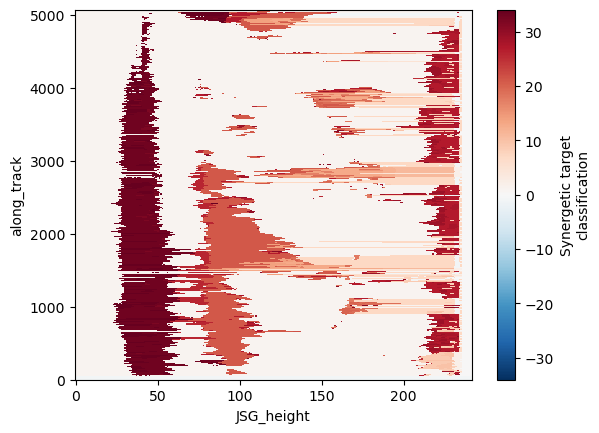

In [19]:
ds['synergetic_target_classification'].plot()
plt.show()

In [27]:
ds_coo = ds.assign_coords(along_track=ds['time'], JSG_height=ds['height'].isel(along_track=0))
ds_coo

<xarray.Dataset> Size: 24MB
Dimensions:                                             (along_track: 5067,
                                                         JSG_height: 242)
Coordinates:
  * along_track                                         (along_track) datetime64[ns] 41kB ...
  * JSG_height                                          (JSG_height) float32 968B ...
Data variables: (12/21)
    time                                                (along_track) datetime64[ns] 41kB ...
    latitude                                            (along_track) float64 41kB ...
    longitude                                           (along_track) float64 41kB ...
    geoid_offset                                        (along_track) float64 41kB ...
    elevation                                           (along_track) float32 20kB ...
    height                                              (along_track, JSG_height) float32 5MB ...
    ...                                                  ...
    CPR_ATLID_status                                    (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_low_resolution_status                     (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_medium_resolution_status                  (along_track, JSG_height) int8 1MB ...
    quality_status                                      (along_track, JSG_height) int8 1MB ...
    quality_low_resolution_status                       (along_track, JSG_height) int8 1MB ...
    quality_medium_resolution_status                    (along_track, JSG_height) int8 1MB ...

In [39]:
from scipy import stats  # will use scipy.stats.mode as the reducer
binned = ds_coo['synergetic_target_classification'].groupby_bins('JSG_height', bins=[0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000])
ds_coarse = binned.reduce(lambda arr, axis: stats.mode(arr, axis=axis, keepdims=False).mode)

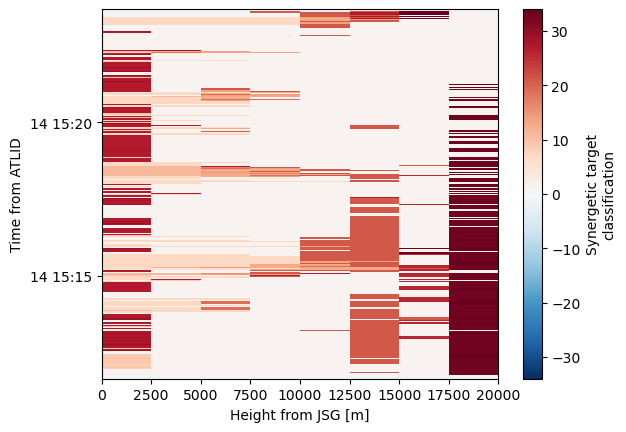

In [40]:
ds_coarse.plot()

## Let's loop!!

In [39]:
len(df)

666

In [40]:
# nooffiles = len(df) #silly name
nooffiles = 10 #testing

In [59]:
frames = []
for fileno in tqdm(range(nooffiles)):
    # print(fileno)
    
    ds_url = df.loc[fileno, "h5_url"]
    
    fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
    with fs.open(ds_url, "rb") as f:
        
        # Open the data
        ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").compute()
        
        # Get the variables
        selection = ds[['latitude', 'longitude', 'land_flag', 'ice_water_path', 'liquid_water_path']]
        # Set unique coordinate to along track dimension
        selection = selection.assign_coords(along_track=ds['time'])
        selection = selection.rename({"along_track":"time"})

        # resample arleady?
        
        frames.append(selection)


00%|██████████| 10/10 [00:13<00:00,  1.39s/it]

In [60]:
radar = xr.concat(frames, dim='time')
radar

<xarray.Dataset> Size: 1MB
Dimensions:            (time: 44336)
Coordinates:
  * time               (time) datetime64[ns] 355kB 2025-03-11T03:57:14.032303...
Data variables:
    latitude           (time) float64 355kB 22.62 22.61 22.61 ... 22.62 22.63
    longitude          (time) float64 355kB 153.1 153.1 153.1 ... 117.5 117.5
    land_flag          (time) int8 44kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ice_water_path     (time) float32 177kB nan nan nan ... 0.005524 0.005936
    liquid_water_path  (time) float32 177kB nan nan nan nan ... nan nan nan nan

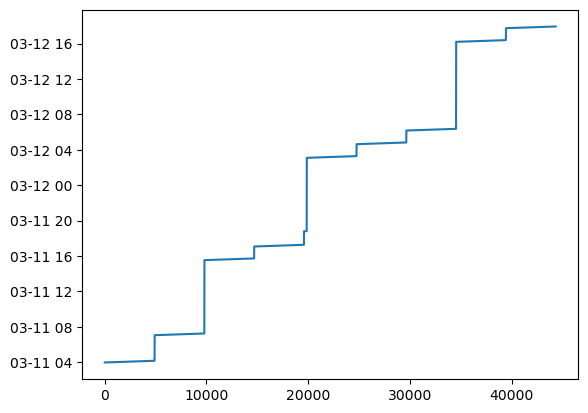

In [61]:
plt.plot(radar.indexes['time'])

## Resampling

In [64]:
radar.resample(time='1s').mean().dropna(dim='time', how='any')

<xarray.Dataset> Size: 24kB
Dimensions:            (time: 593)
Coordinates:
  * time               (time) datetime64[ns] 5kB 2025-03-11T04:00:37 ... 2025...
Data variables:
    latitude           (time) float64 5kB 9.457 9.392 9.003 ... 22.37 22.44 22.5
    longitude          (time) float64 5kB 150.5 150.5 150.4 ... 117.5 117.5
    land_flag          (time) float64 5kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ice_water_path     (time) float32 2kB 0.0008917 0.0007267 ... 0.03007
    liquid_water_path  (time) float32 2kB 0.288 0.2915 0.4745 ... 0.6768 0.5398

In [65]:
radar.time.head(20)

<xarray.DataArray 'time' (time: 20)> Size: 160B
array(['2025-03-11T03:57:14.032303360', '2025-03-11T03:57:14.168041216',
       '2025-03-11T03:57:14.303779328', '2025-03-11T03:57:14.489368448',
       '2025-03-11T03:57:14.625106304', '2025-03-11T03:57:14.760844288',
       '2025-03-11T03:57:14.896582400', '2025-03-11T03:57:15.032320256',
       '2025-03-11T03:57:15.168058368', '2025-03-11T03:57:15.303796352',
       '2025-03-11T03:57:15.489385856', '2025-03-11T03:57:15.625123712',
       '2025-03-11T03:57:15.760861824', '2025-03-11T03:57:15.896599808',
       '2025-03-11T03:57:16.032337920', '2025-03-11T03:57:16.168075776',
       '2025-03-11T03:57:16.303813888', '2025-03-11T03:57:16.489403264',
       '2025-03-11T03:57:16.625141120', '2025-03-11T03:57:16.760879232'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 160B 2025-03-11T03:57:14.032303360 ... 202...
Attributes:
    long_name:  Time

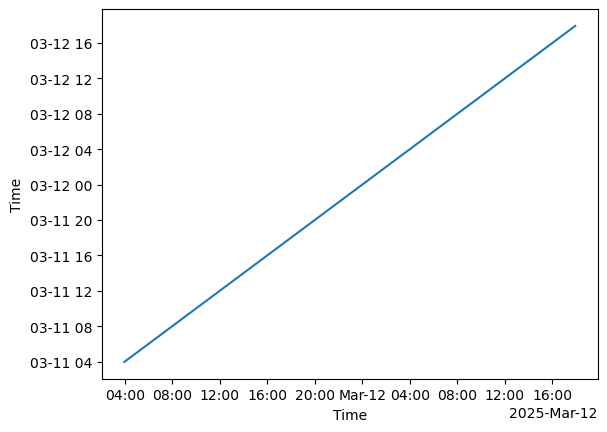

In [66]:
radar.time.plot()
